In [1]:
import os
import gym
import sys
import virl
import random
import itertools
import matplotlib
import collections
import numpy as np
import pandas as pd
from collections import defaultdict
from matplotlib import pyplot as plt
from collections import namedtuple
from collections import defaultdict

import math

%matplotlib inline

if "../" not in sys.path:
    sys.path.append("../") 

In [2]:
# define a couple of helper functions
import pandas as pd
EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])

def plot_episode_stats(stats, smoothing_window,environment,noisy, noshow=False):

    # Plot the episode reward over time,so we can see when did it converge
    fig1 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    plt.savefig('graphs/q_learning_tm/converge graph/average performance vs number of episodes'+ "for q_learning_tm agent" + " " + environment + " " + noisy + " "+ '.png')
    if noshow:
        plt.close(fig1)
    else:
        plt.show(fig1)
    return fig1

In [3]:
# make continuous-state-space into discrete-state-sapce
# for each number within a state, put the number into a bin with 

def quantizing(state):
    bins = []
    for i in range(60):
        bins.append(i*0.00001e+8)
    index = np.digitize(state,bins)-1
    return index[0] + index[1] * 60 + index[2] * 60 * 60 + index[3] * 60 * 60 * 60

# exponential approach

# def quantizing(state):
#     bins = []
#     for i in range(21):
#         bins.append(int(math.exp(i)))
#     index = np.digitize(state,bins)
#     return index[0] + index[1] * 21 + index[2] * 21 * 21 + index[3] * 21 * 21 * 21

In [4]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action. Float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [5]:
def q_learning(env, num_episodes, discount_factor=0.95, alpha=0.3, epsilon=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        #if (i_episode + 1) % 100 == 0:
        
        # Reset the environment and pick the first action
        state = env.reset()
        
        # One step in the environment
        # total_reward = 0.0
        for t in itertools.count():
            
            # Take a step
            #print(quantizing(state))
            #print(quantizing(state))
            action_probs = policy(quantizing(state))
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            print("\rStep {} @ Episode {}/{} ({})".format(
                    t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]), end="")
            #sys.stdout.flush()
            # TD Update
            best_next_action = np.argmax(Q[quantizing(next_state)])    
            td_target = reward + discount_factor * Q[quantizing(next_state)][best_next_action]
            td_delta = td_target - Q[quantizing(state)][action]
            Q[quantizing(state)][action] += alpha * td_delta
           
            if done:
                break
            state = next_state
        
    
    return Q,stats

In [6]:
def run_one_episode(env,policy,environment,noisy):
    #env = virl.Epidemic(stochastic=sto, noisy=n,problem_id=p_id)
    """
    Args:
        stochastic (bool): Is the infection rate sampled from some distribution at the beginning of each episode (default: False)?
        noisy (bool): Is the state a noisy estimate of the true state (default: False)?
        problem_id (int): Deterministic parameterization of the epidemic (default: 0).
    """
    states = []
    rewards = []
    actions = []
    done = False

    s = env.reset()
    states.append(s)
    while not done:
        action_probs = policy(quantizing(s))
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        next_state, reward, done, _ = env.step(action)
    
        states.append(next_state)
        rewards.append(reward)
        actions.append(action)
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    print(show_action(actions))
    labels = ['s[0]: susceptibles', 's[1]: infectious', 's[2]: quarantined', 's[3]: recovereds']
    states = np.array(states)
    for i in range(4):
        axes[0].set_title("The states analysis for" + " " + environment + " " + noisy + " " + "for q-learning-tm")
        axes[0].plot(states[:,i], label=labels[i]);
        axes[0].set_xlabel('weeks since start of epidemic')
        axes[0].set_ylabel('State s(t)')
        axes[0].legend()
        axes[1].plot(rewards);
        axes[1].set_title('The Reward to each action' + " " + environment + " " + noisy + " " + "for q-learning-tm")
        axes[1].set_xlabel('weeks since start of epidemic')
        axes[1].set_ylabel('reward r(t)')
    
    print('total reward', np.sum(rewards))
    plt.savefig('graphs/q_learning_tm/state_and_reward/state and reward for'+ " " + environment + " " + noisy + " " + "for q-learning-tm" + '.png')
    return actions

In [7]:
def q_learning_tm_train_and_predict(env,num_episodes,environment,noisy):
    # Instantiate a FunctionApproximator (i.e. the linear function approximator)

    Q,stats = q_learning(env, num_episodes)
    policy = make_epsilon_greedy_policy(Q,0.4,env.action_space.n)
    actions = run_one_episode(env,policy,environment,noisy)
    return stats

In [8]:
def show_action(actions):
    outcome = " " 
    for i in range(len(actions)):
        outcome += ("week " + str("{:2}".format(i+1)) + " : ")
        if actions[i] == 0:
            outcome += ("%-17s" %("None"))
        if actions[i] == 1:
            outcome += ("%-17s" %("Full Lockdown"))
        if actions[i] == 2:
            outcome += ("%-17s" %("Track & Trace"))
        if actions[i] == 3:
            outcome += ("%-17s" %("Social Distancing"))
        if len(actions) - 1 != i:
            outcome += (" -> ")
        if (i+1) % 4 == 0:
            outcome += "\n"
    return outcome

In [9]:
def overall_training_and_evaluation(num_episodes):
    
    stats_for_problems_nnoise = []
    for i in range (10):
        env = virl.Epidemic(problem_id=i,noisy=False)
        print("This is problem" + " " + str(i) + " " + "without noise for q-learning-tm")
        stats0 = q_learning_tm_train_and_predict(env,num_episodes,"problem" + " " + str(i),"without noise")
        stats_for_problems_nnoise.append(stats0)
        
    stats_for_problems_noise = []
    for j in range (10):
        env = virl.Epidemic(problem_id=j,noisy=True)
        print("This is problem" + " " + str(j) + " " + "with noise for q-learning-tm")
        stats1 = q_learning_tm_train_and_predict(env,num_episodes,"problem" + " " + str(j),"with noise")
        stats_for_problems_noise.append(stats1)
        

    env = virl.Epidemic(stochastic=True,noisy=False)
    print("This is stochastic problem " +  " " + "without noise for q-learning-tm")
    stats2 = q_learning_tm_train_and_predict(env,num_episodes,"stochastic","without noise")
    
    env = virl.Epidemic(stochastic=True,noisy=True)
    print("This is stochastic problem " +  " " + "with noise for q-learning-tm")
    stats3 = q_learning_tm_train_and_predict(env,num_episodes,"stochastic","with noise")
    
    print("----------------------------------Learning Curves----------------------------------------------")
    return stats_for_problems_nnoise,stats_for_problems_noise,stats2,stats3

In [10]:
def show_graphs_q_learning_tm(stats_for_problems_nnoise,stats_for_problems_noise,stats2,stats3):
    '''Used for ploting the converging curve for each training problem and environments'''
    
    for i in range(len(stats_for_problems_nnoise)):
        plot_episode_stats(stats_for_problems_nnoise[i],100,"problem" + " " + str(i),"without noise")
        print("This is the convergence graphs for problem" + " " + str(i) + " " + "without noise for q-learning-tm")
    for j in range(len(stats_for_problems_noise)):
        plot_episode_stats(stats_for_problems_noise[j],100,"problem" + " " + str(j),"with noise")
        print("This is the convergence graphs for problem" + " " + str(j) + " " + "with noise for q-learning-tm")
        
    plot_episode_stats(stats2,100,"stochastic","without noise")
    print("This is the convergence graphs for stochastic environment" +  " " + "without noise for q-learning-tm")
    
    plot_episode_stats(stats3,100,"stochastic","with noise")
    print("This is the convergence graphs for stochastic environment" +  " " + "with noise for q-learning-tm")

In [11]:
def visualization_for_q_learning_tm():
    # Train and evaluate as well as drawing state graph and reward graph
    stats_for_problems_nnoise,stats_for_problems_noise,stats2,stats3 = overall_training_and_evaluation(2000)
    # Plot the converging curve
    show_graphs_q_learning_tm(stats_for_problems_nnoise,stats_for_problems_noise,stats2,stats3)

This is problem 0 without noise for q-learning-tm
Step 51 @ Episode 2000/2000 (-1.5934555679131241) week  1 : Track & Trace     -> week  2 : Track & Trace     -> week  3 : Track & Trace     -> week  4 : Track & Trace     -> 
week  5 : Track & Trace     -> week  6 : None              -> week  7 : Full Lockdown     -> week  8 : Track & Trace     -> 
week  9 : None              -> week 10 : Track & Trace     -> week 11 : Track & Trace     -> week 12 : Track & Trace     -> 
week 13 : Track & Trace     -> week 14 : None              -> week 15 : None              -> week 16 : Track & Trace     -> 
week 17 : Full Lockdown     -> week 18 : Social Distancing -> week 19 : Full Lockdown     -> week 20 : Track & Trace     -> 
week 21 : Social Distancing -> week 22 : Track & Trace     -> week 23 : Full Lockdown     -> week 24 : Track & Trace     -> 
week 25 : Full Lockdown     -> week 26 : Track & Trace     -> week 27 : Track & Trace     -> week 28 : Track & Trace     -> 
week 29 : Track & Trace  

This is problem 5 without noise for q-learning-tm
Step 51 @ Episode 2000/2000 (-2.300499085829959) week  1 : Full Lockdown     -> week  2 : Full Lockdown     -> week  3 : None              -> week  4 : Full Lockdown     -> 
week  5 : Track & Trace     -> week  6 : Social Distancing -> week  7 : Full Lockdown     -> week  8 : Full Lockdown     -> 
week  9 : Full Lockdown     -> week 10 : Full Lockdown     -> week 11 : Full Lockdown     -> week 12 : Full Lockdown     -> 
week 13 : Social Distancing -> week 14 : Full Lockdown     -> week 15 : Full Lockdown     -> week 16 : Full Lockdown     -> 
week 17 : Full Lockdown     -> week 18 : Social Distancing -> week 19 : Full Lockdown     -> week 20 : Social Distancing -> 
week 21 : Full Lockdown     -> week 22 : Full Lockdown     -> week 23 : Full Lockdown     -> week 24 : Full Lockdown     -> 
week 25 : Full Lockdown     -> week 26 : Full Lockdown     -> week 27 : Track & Trace     -> week 28 : Social Distancing -> 
week 29 : Full Lockdown   

Step 51 @ Episode 2000/2000 (-0.9425670628566449) week  1 : Social Distancing -> week  2 : None              -> week  3 : Social Distancing -> week  4 : Social Distancing -> 
week  5 : Social Distancing -> week  6 : Social Distancing -> week  7 : Social Distancing -> week  8 : Social Distancing -> 
week  9 : Social Distancing -> week 10 : Social Distancing -> week 11 : Social Distancing -> week 12 : Social Distancing -> 
week 13 : Track & Trace     -> week 14 : Social Distancing -> week 15 : Track & Trace     -> week 16 : Social Distancing -> 
week 17 : Full Lockdown     -> week 18 : Social Distancing -> week 19 : Social Distancing -> week 20 : Track & Trace     -> 
week 21 : Track & Trace     -> week 22 : None              -> week 23 : Social Distancing -> week 24 : Full Lockdown     -> 
week 25 : Social Distancing -> week 26 : Social Distancing -> week 27 : Social Distancing -> week 28 : Social Distancing -> 
week 29 : Social Distancing -> week 30 : Social Distancing -> week 31 : Ful

This is problem 5 with noise for q-learning-tm
Step 51 @ Episode 2000/2000 (-2.3504005007277873) week  1 : Track & Trace     -> week  2 : Track & Trace     -> week  3 : None              -> week  4 : Track & Trace     -> 
week  5 : Track & Trace     -> week  6 : Full Lockdown     -> week  7 : Track & Trace     -> week  8 : Track & Trace     -> 
week  9 : None              -> week 10 : Track & Trace     -> week 11 : Track & Trace     -> week 12 : Social Distancing -> 
week 13 : Full Lockdown     -> week 14 : Track & Trace     -> week 15 : Track & Trace     -> week 16 : Track & Trace     -> 
week 17 : Track & Trace     -> week 18 : Full Lockdown     -> week 19 : Social Distancing -> week 20 : Track & Trace     -> 
week 21 : Track & Trace     -> week 22 : Track & Trace     -> week 23 : Track & Trace     -> week 24 : Track & Trace     -> 
week 25 : Track & Trace     -> week 26 : None              -> week 27 : Track & Trace     -> week 28 : Track & Trace     -> 
week 29 : Track & Trace     

This is stochastic problem  without noise for q-learning-tm
Step 51 @ Episode 2000/2000 (-2.1823057560532035) week  1 : Social Distancing -> week  2 : None              -> week  3 : Full Lockdown     -> week  4 : Track & Trace     -> 
week  5 : Full Lockdown     -> week  6 : Full Lockdown     -> week  7 : Full Lockdown     -> week  8 : Full Lockdown     -> 
week  9 : Full Lockdown     -> week 10 : Full Lockdown     -> week 11 : Full Lockdown     -> week 12 : None              -> 
week 13 : Social Distancing -> week 14 : Full Lockdown     -> week 15 : Full Lockdown     -> week 16 : Full Lockdown     -> 
week 17 : Full Lockdown     -> week 18 : Full Lockdown     -> week 19 : Full Lockdown     -> week 20 : Full Lockdown     -> 
week 21 : Full Lockdown     -> week 22 : Full Lockdown     -> week 23 : Full Lockdown     -> week 24 : Track & Trace     -> 
week 25 : Full Lockdown     -> week 26 : Track & Trace     -> week 27 : Full Lockdown     -> week 28 : Full Lockdown     -> 
week 29 : Full 

<ipython-input-6-f8ec12ba7cfc>:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, 2, figsize=(20, 8))


This is stochastic problem  with noise for q-learning-tm
Step 51 @ Episode 2000/2000 (-2.0148984715797065) week  1 : Social Distancing -> week  2 : Social Distancing -> week  3 : Full Lockdown     -> week  4 : Social Distancing -> 
week  5 : Full Lockdown     -> week  6 : Social Distancing -> week  7 : Social Distancing -> week  8 : Track & Trace     -> 
week  9 : Social Distancing -> week 10 : Social Distancing -> week 11 : Social Distancing -> week 12 : Social Distancing -> 
week 13 : Social Distancing -> week 14 : Social Distancing -> week 15 : Full Lockdown     -> week 16 : Social Distancing -> 
week 17 : Social Distancing -> week 18 : Social Distancing -> week 19 : Social Distancing -> week 20 : None              -> 
week 21 : Track & Trace     -> week 22 : Social Distancing -> week 23 : Social Distancing -> week 24 : Full Lockdown     -> 
week 25 : None              -> week 26 : None              -> week 27 : Social Distancing -> week 28 : Social Distancing -> 
week 29 : Track & 

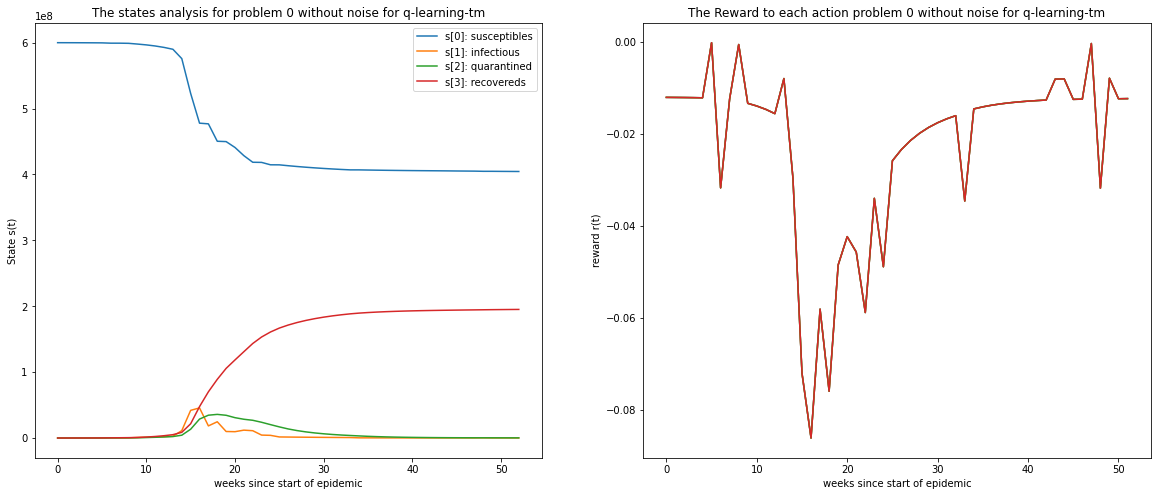

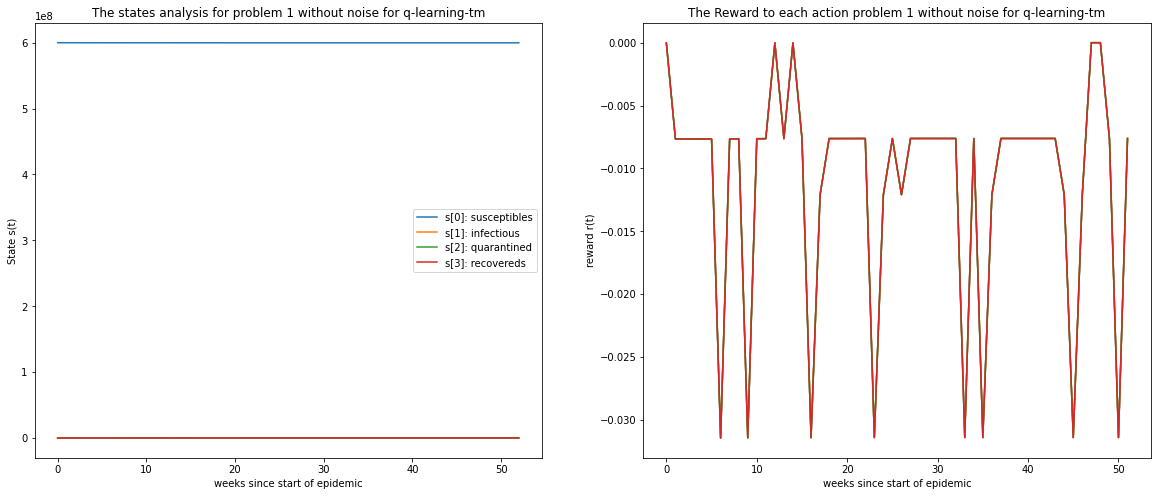

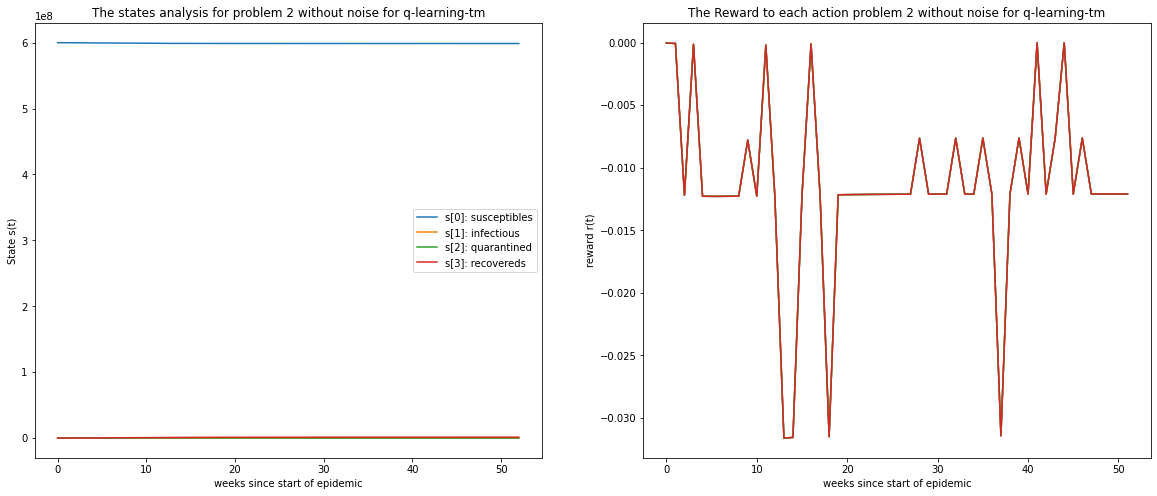

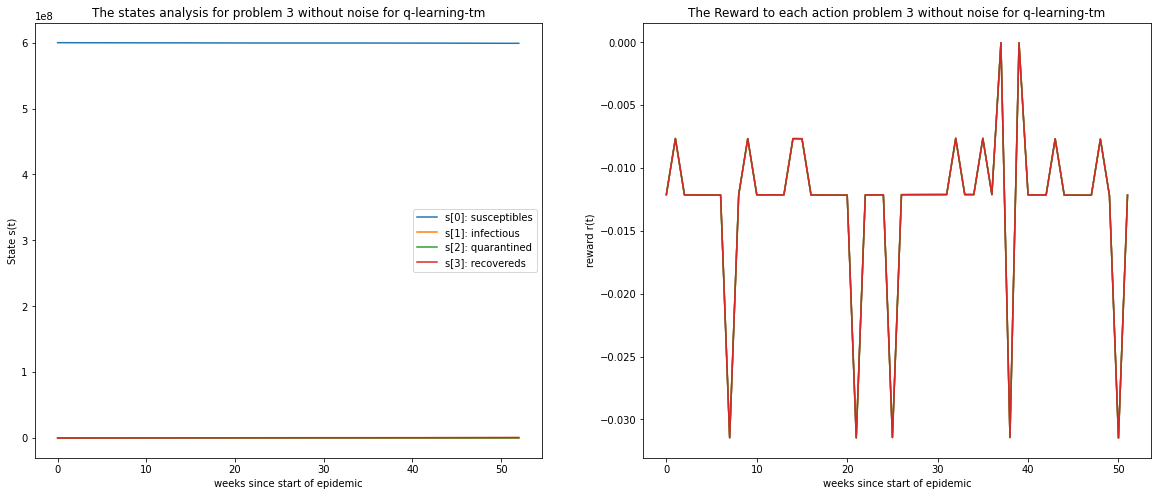

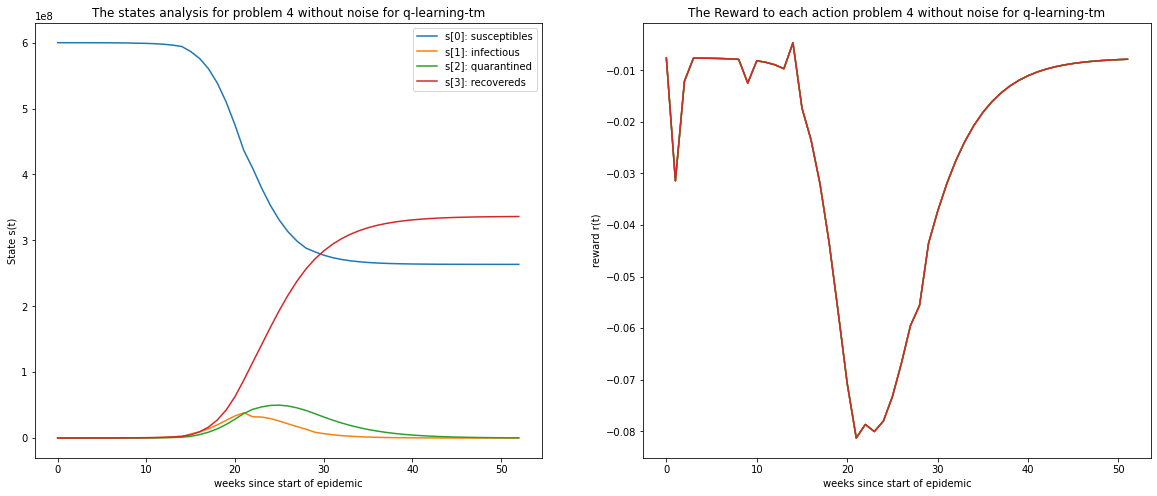

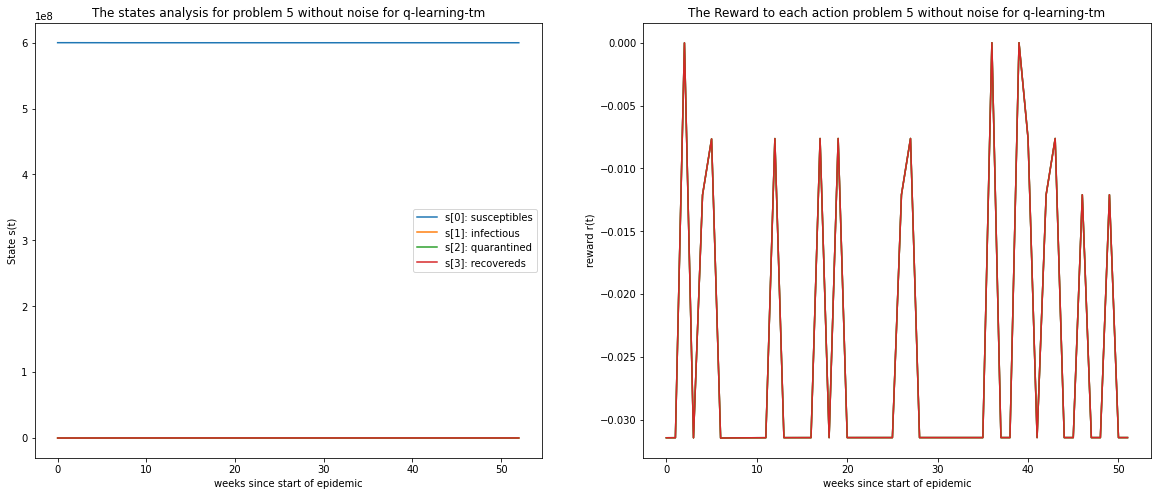

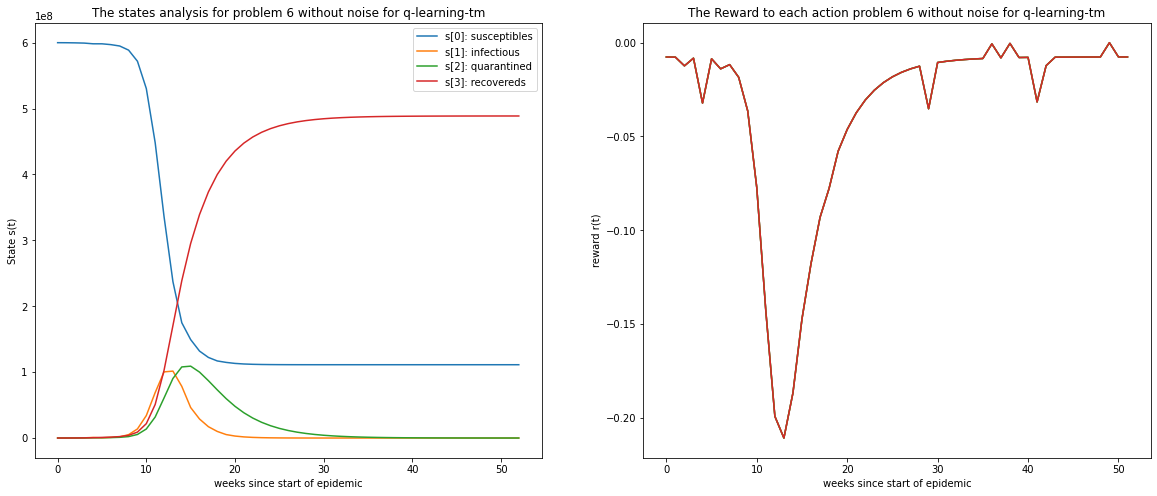

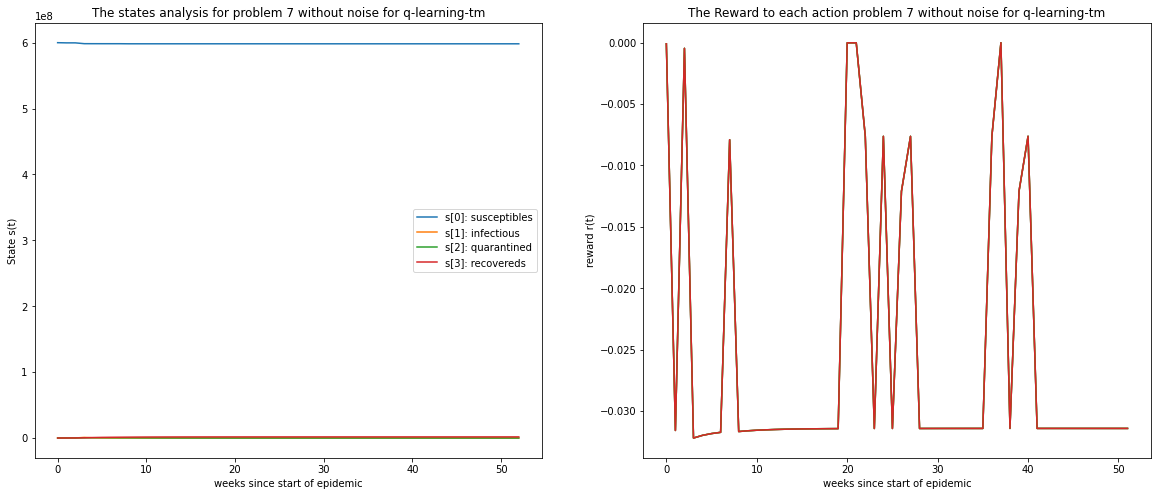

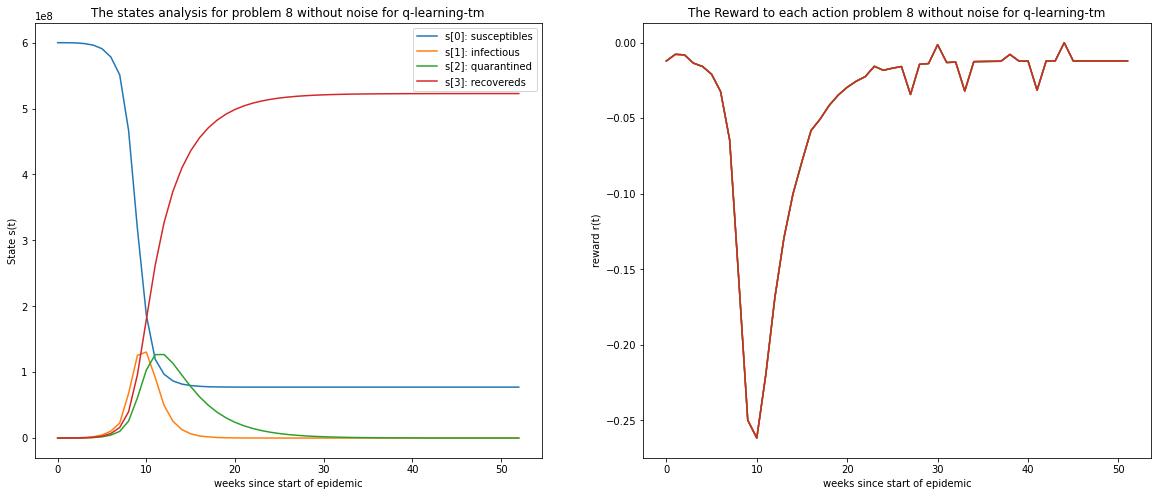

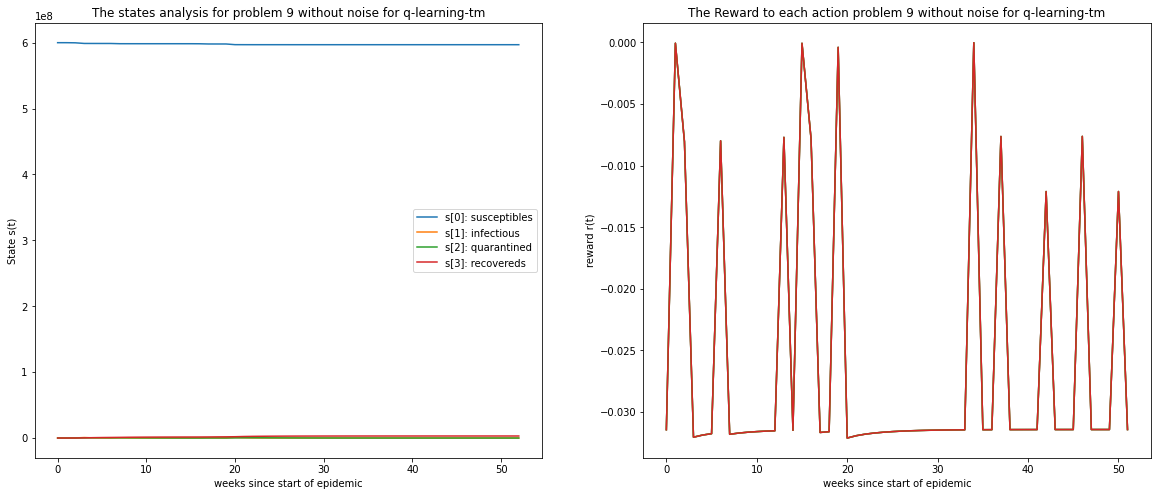

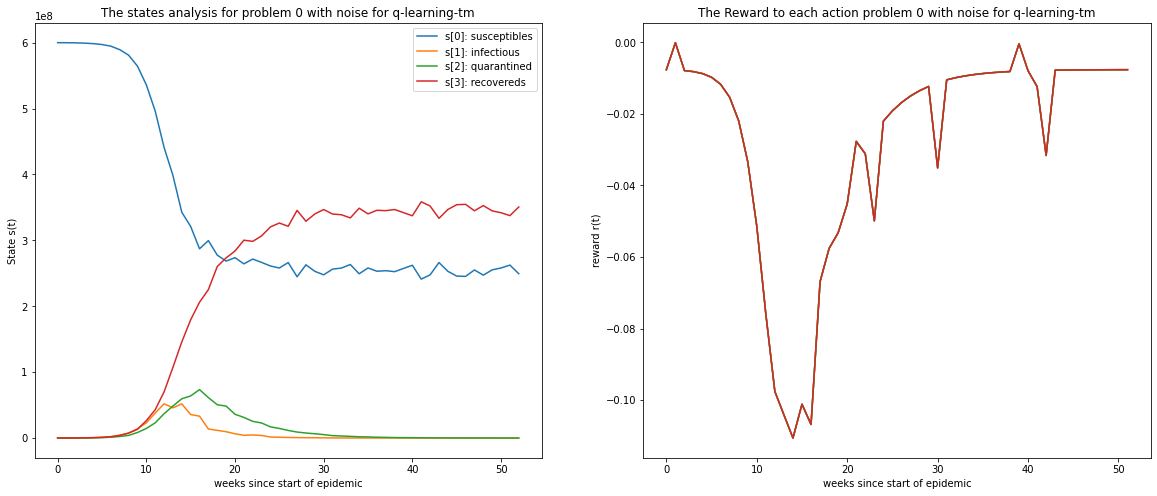

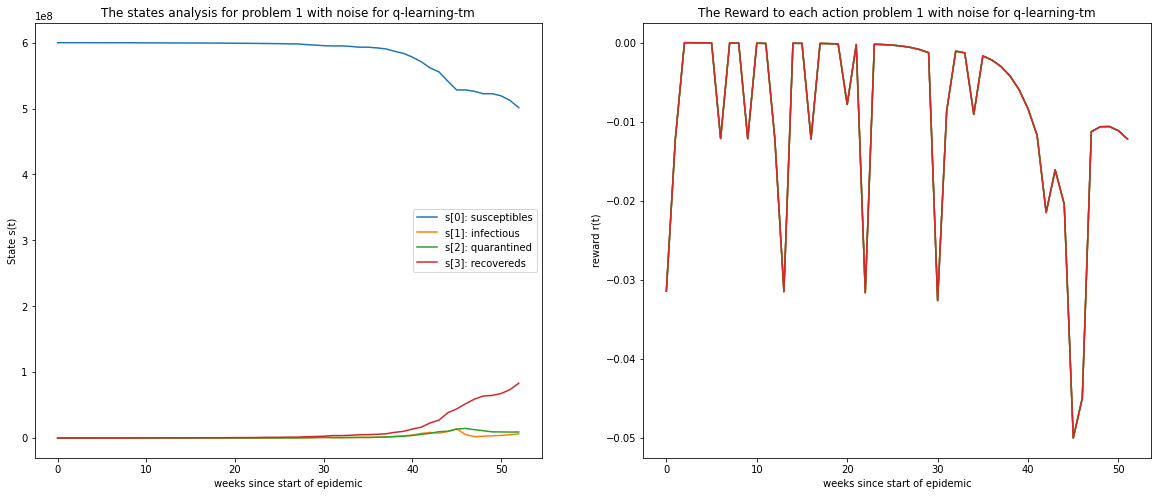

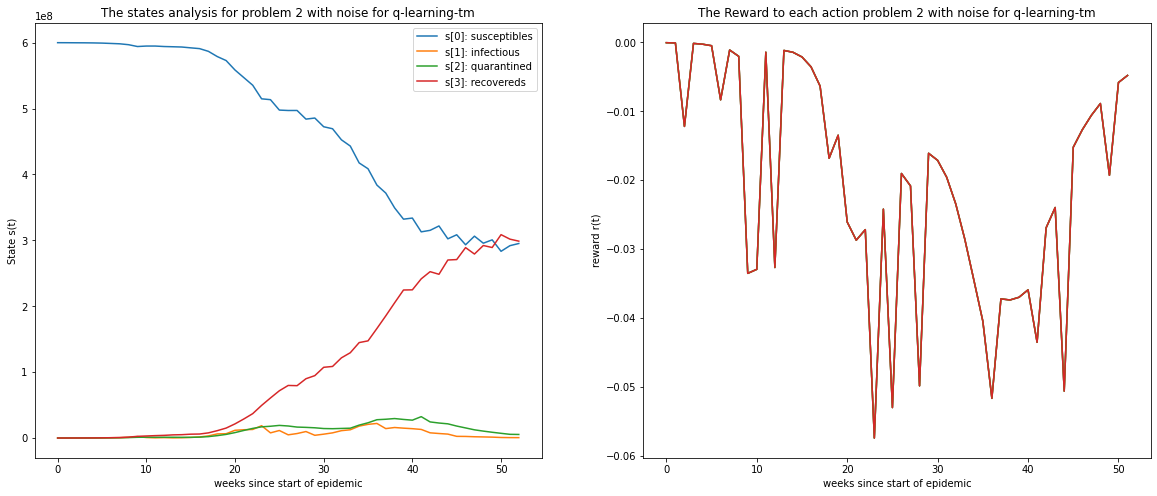

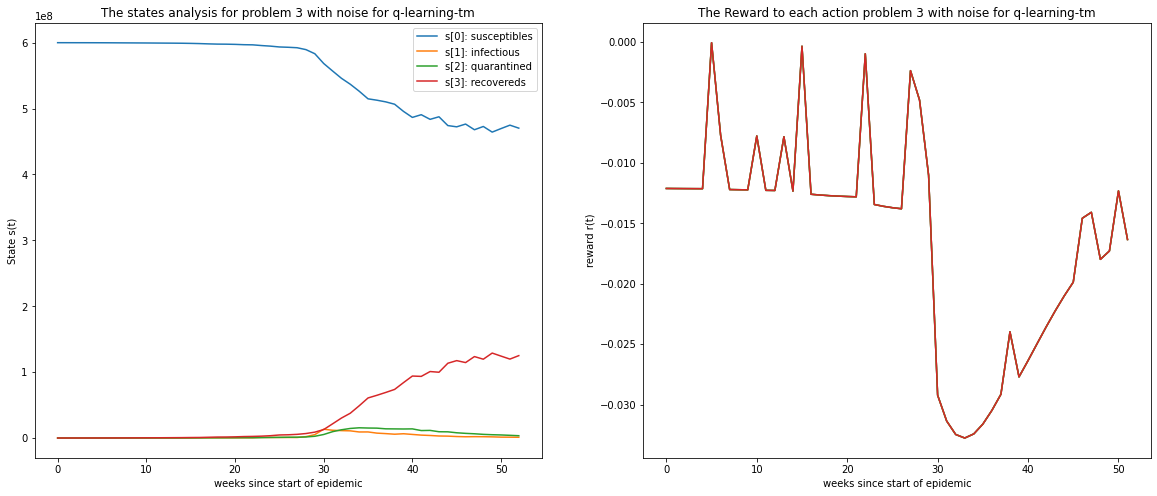

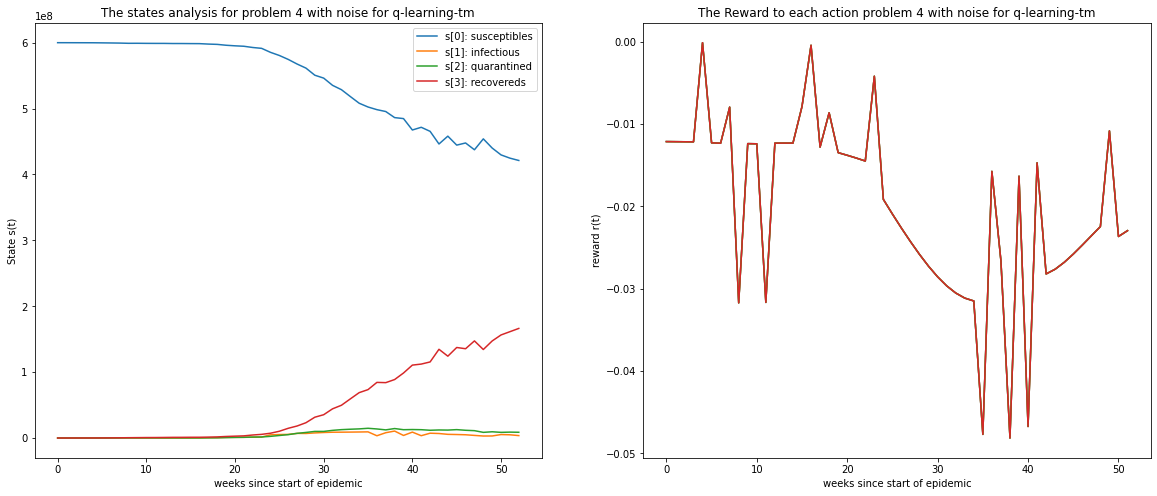

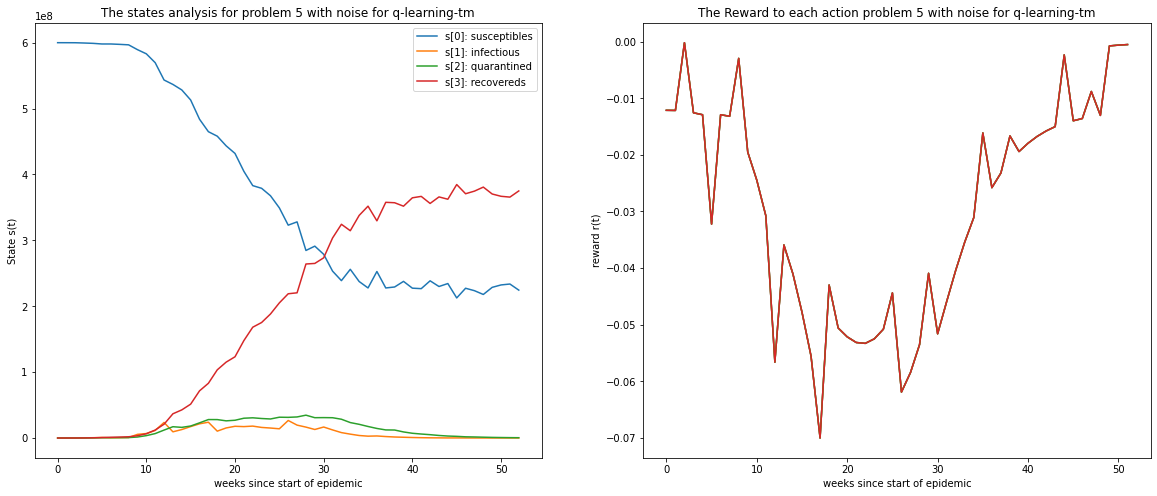

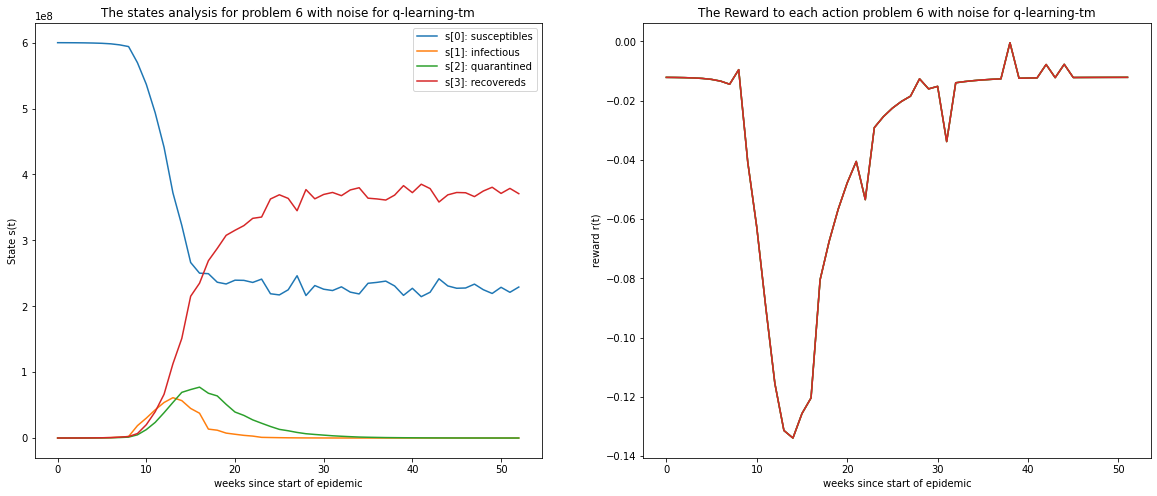

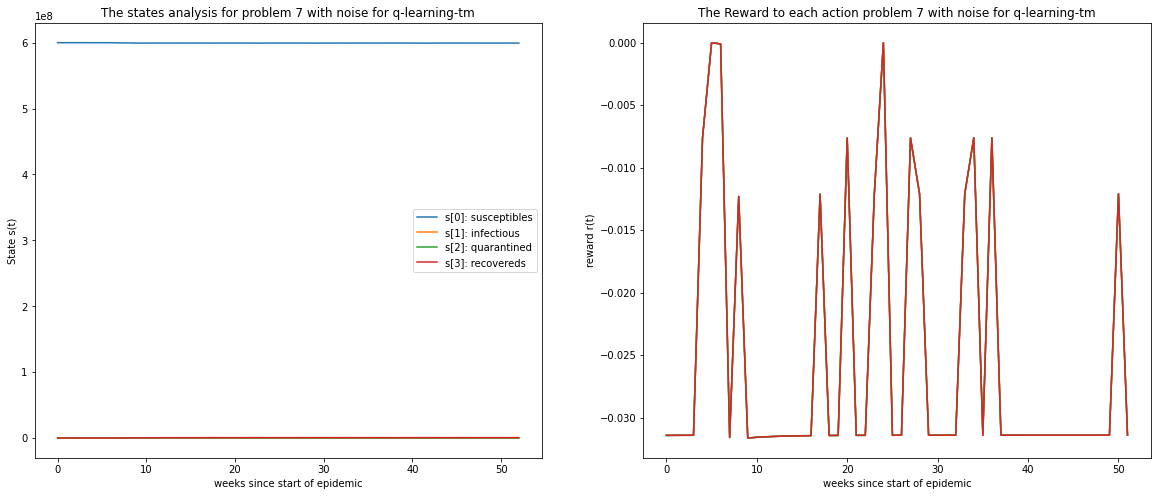

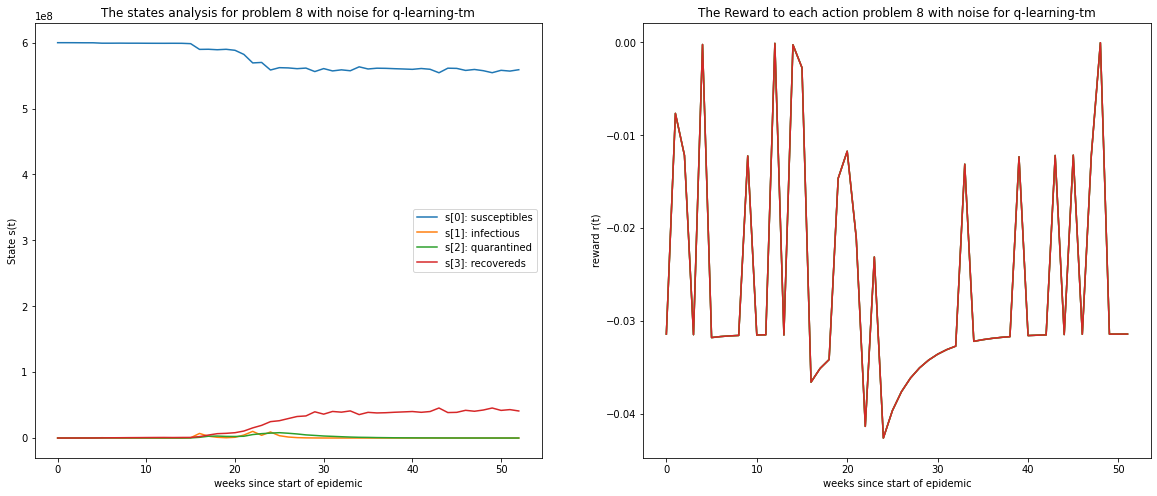

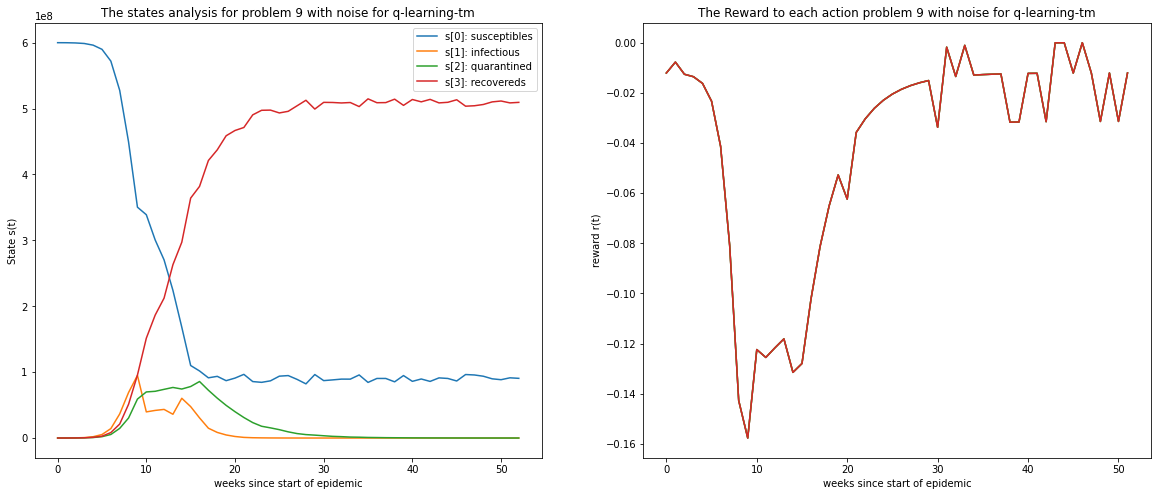

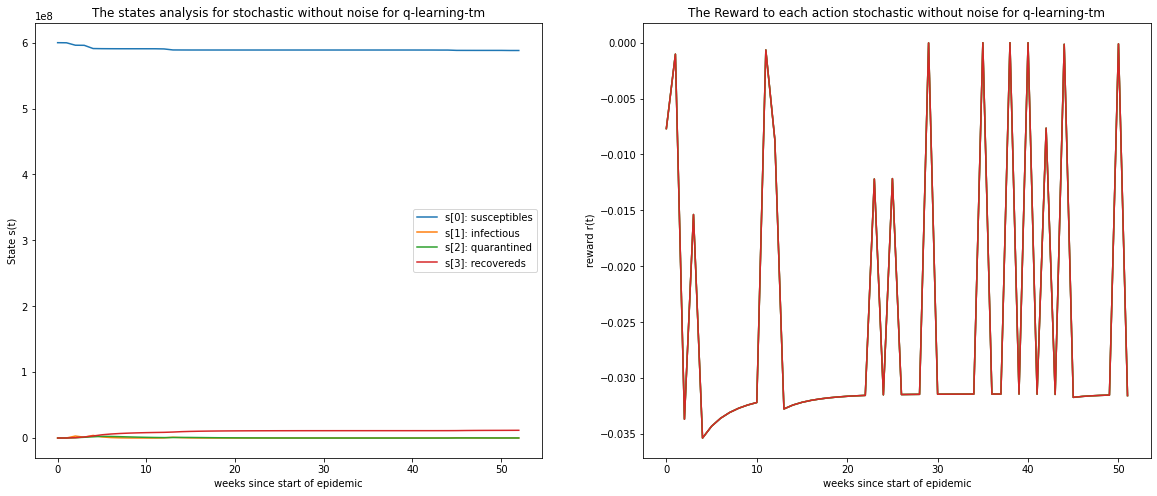

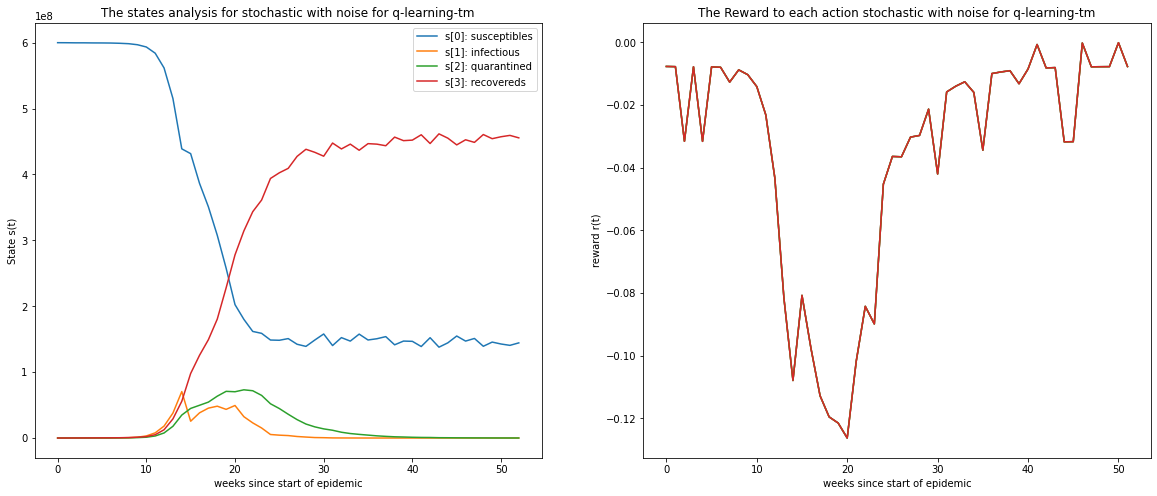

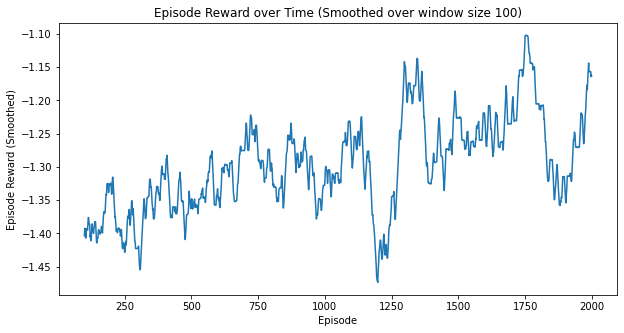

This is the convergence graphs for problem 0 without noise for q-learning-tm


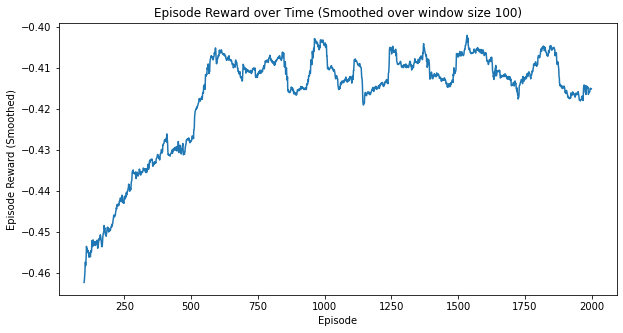

This is the convergence graphs for problem 1 without noise for q-learning-tm


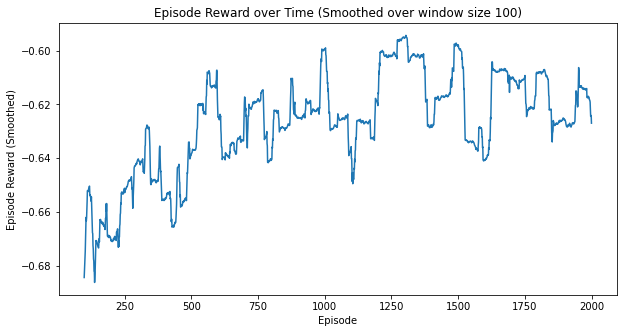

This is the convergence graphs for problem 2 without noise for q-learning-tm


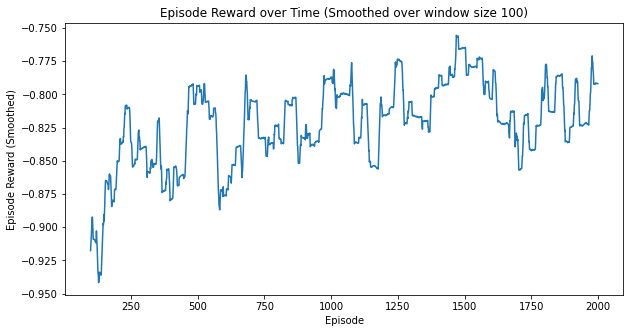

This is the convergence graphs for problem 3 without noise for q-learning-tm


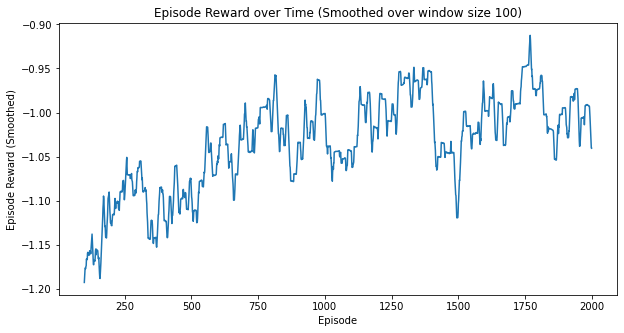

This is the convergence graphs for problem 4 without noise for q-learning-tm


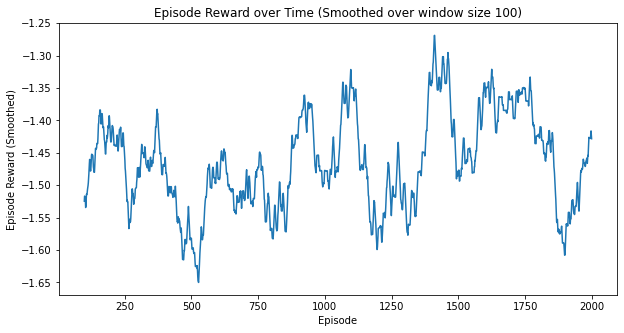

This is the convergence graphs for problem 5 without noise for q-learning-tm


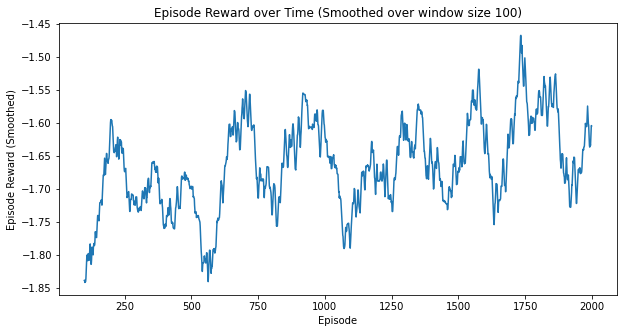

This is the convergence graphs for problem 6 without noise for q-learning-tm


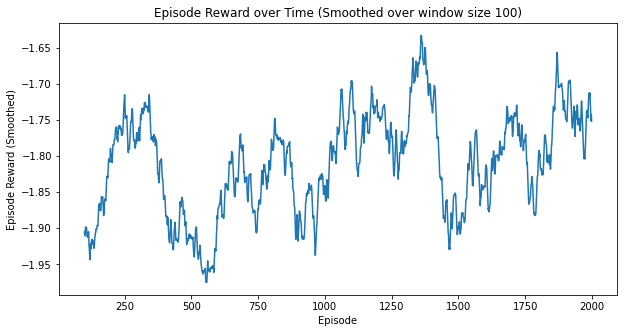

This is the convergence graphs for problem 7 without noise for q-learning-tm


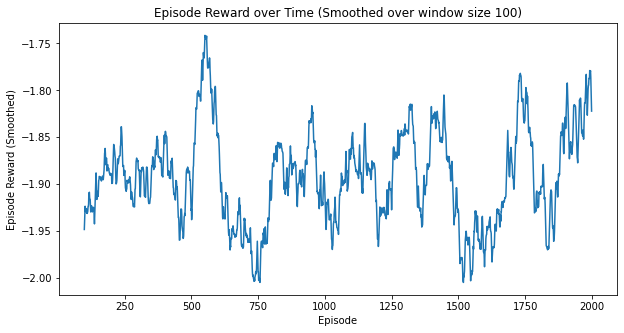

This is the convergence graphs for problem 8 without noise for q-learning-tm


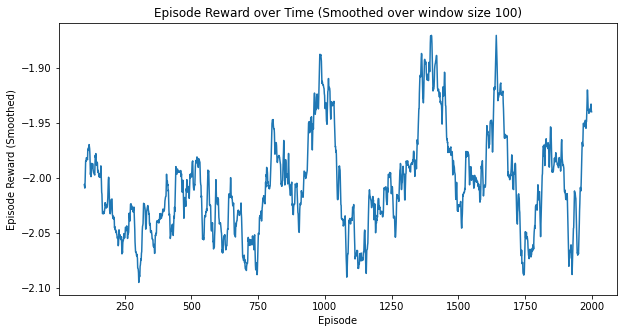

This is the convergence graphs for problem 9 without noise for q-learning-tm


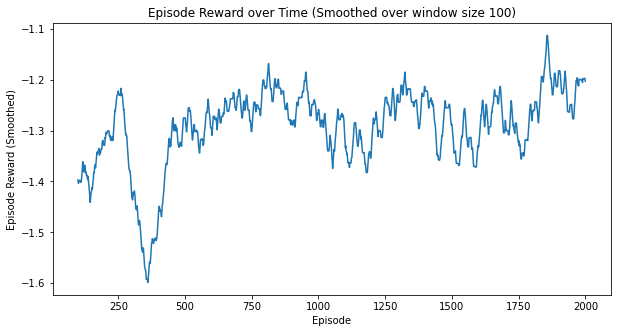

This is the convergence graphs for problem 0 with noise for q-learning-tm


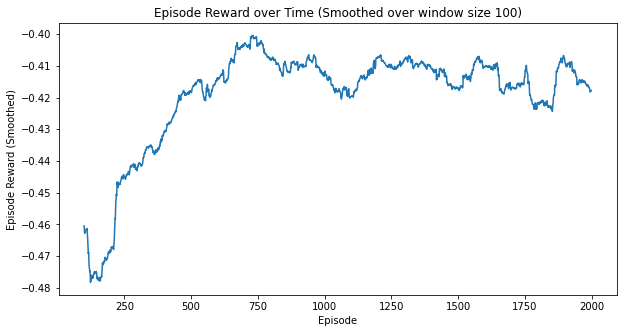

This is the convergence graphs for problem 1 with noise for q-learning-tm


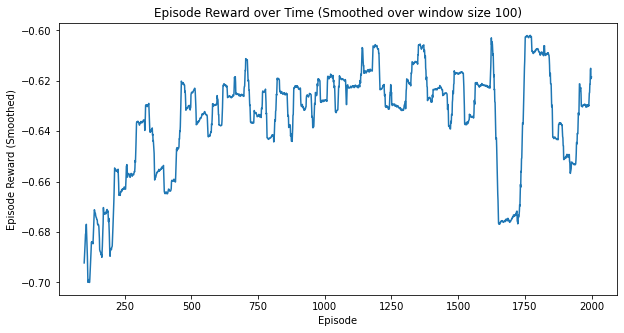

This is the convergence graphs for problem 2 with noise for q-learning-tm


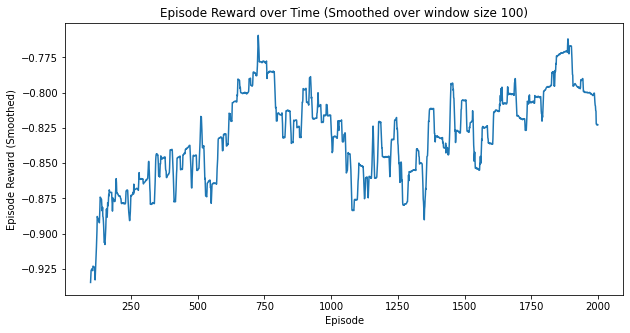

This is the convergence graphs for problem 3 with noise for q-learning-tm


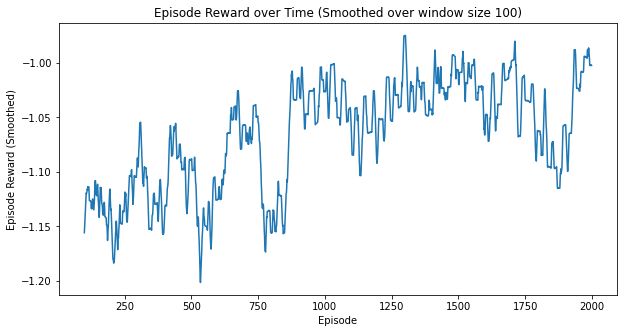

This is the convergence graphs for problem 4 with noise for q-learning-tm


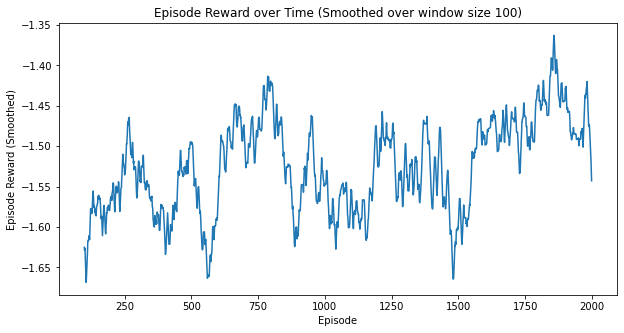

This is the convergence graphs for problem 5 with noise for q-learning-tm


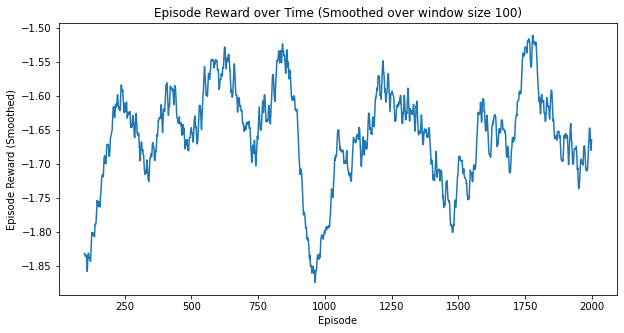

This is the convergence graphs for problem 6 with noise for q-learning-tm


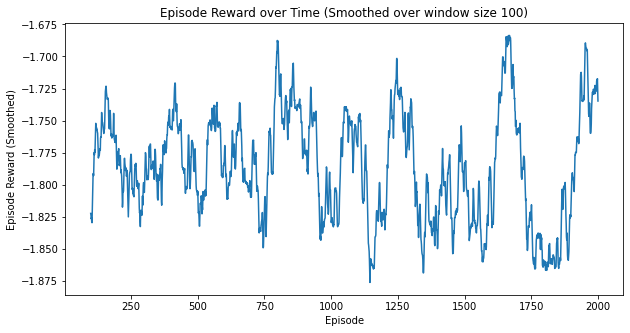

This is the convergence graphs for problem 7 with noise for q-learning-tm


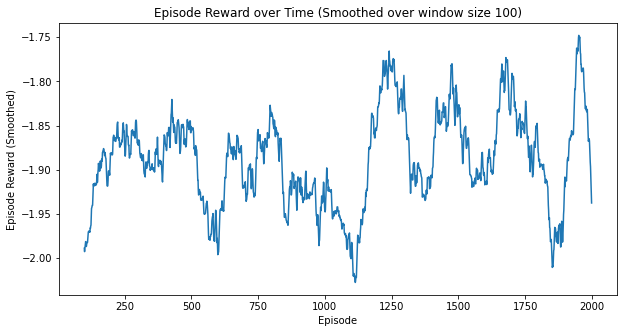

This is the convergence graphs for problem 8 with noise for q-learning-tm


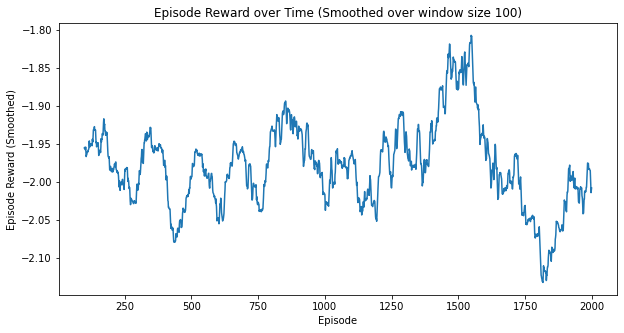

This is the convergence graphs for problem 9 with noise for q-learning-tm


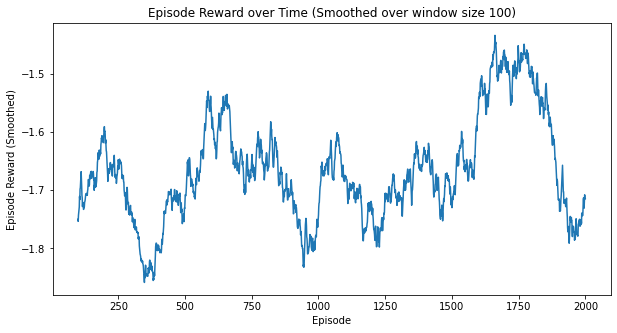

This is the convergence graphs for stochastic environment without noise for q-learning-tm


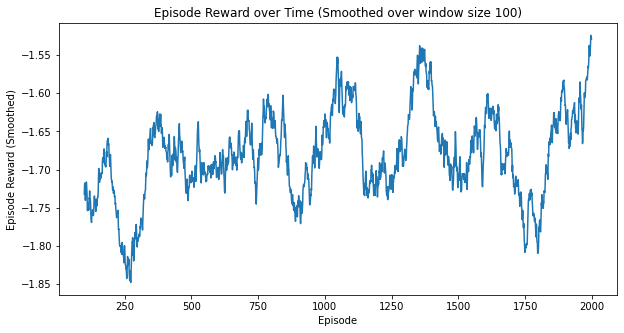

This is the convergence graphs for stochastic environment with noise for q-learning-tm


In [12]:
# visualization_for_q_learning_tm()